# How To Use XModalix

X-Modalix is our implementation of a cross-modal autoencoder.  
This tutorial follows the structure of `Getting Started - Vanillix`, but is less extensive because our pipeline works similarly across different architectures. Here, we focus only on X-Modalix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the XModalix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` tutorial first.

## XModalix Theory

The core idea of a cross-modal autoencoder is to align the latent spaces of different data modalities.  
Once the latent distributions are aligned, we can translate between modalities by feeding data from one modality into its encoder and then passing the latent space to the decoder of the target modality.

The underlying models are separate VAEs—one for each data modality—which are trained in parallel. Their latent spaces are closely aligned so that modalities are hard to discriminate, but sample variation is preserved.  
To achieve this alignment, the VAE loss function is extended with the following terms:

- *Adversarial* loss term: In parallel with the VAEs, a third neural network (latent space classifier) is trained to discriminate the embeddings of different modalities. Analogous to a GAN, the inverse of this classifier loss is added to the VAE loss to enforce latent space alignment.  

- *Paired* loss term: Alignment is further enforced by minimizing the distance between samples with paired measurements across modalities. While unpaired samples are allowed, we recommend that most samples are paired (present in all modalities).  

- *Class-based* loss term: This semi-supervised term minimizes distances among samples of the same class. Class membership is defined in the annotation data (e.g., cancer type, cell type). In each iteration, the class mean in the latent space is computed, and distances from individual samples to the class mean are minimized. See our `Preprint [TODO]` for more details.  

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/729f3e8172a722e7c3681298719d9d4b59e313d9/images/xmodalix_scheme.svg" alt="xmodalix_scheme" width="1200"/>

## What You'll Learn

As a showcase for data modality translation with X-Modalix, we will use cancer gene expression from TCGA in combination with handwritten digits from the [MNIST dataset](https://keras.io/api/datasets/mnist/).  
Our goal is to translate gene expression signatures of five selected cancer subtypes into images of digits, with each cancer subtype class mapped to a digit between 0–4.  

In practice, these images could be histopathological images or any other data modality.  
Before we show data preparation and X-Modalix training, we provide background on cross-modal VAEs as proposed by [Yang & Uhler](https://arxiv.org/abs/1902.03515).  

While following this showcase, you will learn how to:

1. **Initialize** the pipeline and run it. <br><br>
2. Understand the X-Modalix-specific **pipeline steps** (paired vs. unpaired data). <br><br>
3. Access X-Modalix-specific **results** (sub-results for modality autoencoders). <br><br>
4. **Visualize** and **evaluate** the outputs. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

Let’s get started! 🚀


## 1) Initialize and Run XModalix

In this example, we read our input data from files.  
The file locations are defined in the config via a section called `DataConfig` (see details in the Python code below).  

We highlight a few custom config parameters for XModalix. For a deeper dive into the config object, see [1]:

- `pretrain_epochs`: Before training the full X-Modalix, the sub-VAEs of each modality can be pretrained. This parameter can be set globally for all modalities or individually per modality and specifies the number of pretraining epochs.  
- `gamma`: Hyperparameter to weight the adversarial loss term.  
- `delta_pair`: Hyperparameter to weight the paired loss term.  
- `delta_class`: Hyperparameter to weight the class-based loss term.  

### ❗❗ Requirements: Getting Tutorial Data ❗❗

You can use the following bash commands to download the data and set up the correct folder structure.  
**Assumption:** you are in the root of `autoencodix_package`.

```bash
mkdir -p data
cd data
wget "https://cloud.scadsai.uni-leipzig.de/index.php/s/bq64MaQyZGZfN64/download/XModalix-Tut-data.zip"
unzip XModalix-Tut-data.zip
```

### Extra 2: Get correct path
We assume you are in the root of the package. The following code ensures that the correct paths are used.
[1] Tutorials/DeepDives/ConfigTutorial.ipynb

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")


Changed to: /Users/maximilianjoas/development/autoencodix_package


### Extra 3: Data Assumptions

X-Modalix supports two special cases:  
(a) image data, and  
(b) unpaired data.  

This introduces specific requirements for the input data. In the config object, the `DataConfig` must be populated with the relevant information. Example code:

```python
imganno_file = os.path.join("data/XModalix-Tut-data/tcga_mappings.txt")
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")
clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")

dc = DataConfig(
    data_info={
        "img": DataInfo(
            file_path=img_root,
            data_type="IMG",
            scaling="MINMAX",
            translate_direction="to",
            pretrain_epochs=3,
            # extra_anno_file=imganno_file,
        ),
        "rna": DataInfo(
            file_path=rna_file,
            data_type="NUMERIC",
            scaling="MINMAX",
            translate_direction="from",
        ),
        "anno": DataInfo(
            file_path=clin_file,
            data_type="ANNOTATION",
            sep="\t"
        ),
    }
)
```
**Image Data Requirements**

- Specify the root folder where the images are located. The preprocessor will automatically read all images and convert them into tensors.  
- Supported image extensions (case-insensitive): `".jpg"`, `".jpeg"`, `".png"`, `".tif"`, `".tiff"`.  
- A mapping between each image filename (without directories) and a `sample_id` is required, along with any additional metadata.  

To provide this mapping, you must supply a **global annotation file** that contains all `sample_id`s and metadata columns, including one column with the image paths.  
- Use the config parameter `img_path_col` to define the name of the column containing image paths (default: `"img_paths"`).  
- See your `clin_file` for an example.

**Translation Direction**

- X-Modalix trains a shared latent alignment, enabling translation between all modalities.  
- To keep results consistent, users should define a `translate_direction` in the config.  
- If you want to change the direction or translate a different pair, you can specify this in the `predict` step (see [Section 3](#3-access-xmodalix-results)).


In [2]:
import os
import pandas as pd
import autoencodix as acx

from autoencodix.configs.xmodalix_config import XModalixConfig
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.modeling._imgfast_architecture import ImageVAEArchitecture
print(f"Current directory: {os.getcwd()}")

clin_file = os.path.join("./data/XModalix-Tut-data/combined_clin_formatted.parquet")
clin_df = pd.read_parquet(clin_file)
print("First five image paths:")
print(clin_df["img_paths"].to_list()[0:5])
print("\n")
clin_df.head()


Current directory: /Users/maximilianjoas/development/autoencodix_package
First five image paths:
['2331_label_0.png', '2332_label_0.png', '2333_label_0.png', '2334_label_0.png', '2335_label_0.png']




,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,TISSUE_PROSPECTIVE_COLLECTION_INDICATOR,TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR,TISSUE_SOURCE_SITE_CODE,TUMOR_TISSUE_SITE,ANEUPLOIDY_SCORE,...,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,img_paths
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,ILC,Breast Cancer,Breast Invasive Lobular Carcinoma,Infiltrating Lobular Carcinoma,unknown,No,Yes,3C,Breast,19.0,...,0:LIVING,133.050597,0:ALIVE OR DEAD TUMOR FREE,133.050597,1:Recurred/Progressed,59.440444,1:PROGRESSION,59.440444,EUR,2331_label_0.png
TCGA-3C-AALI-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,unknown,No,Yes,3C,Breast,22.0,...,0:LIVING,131.669790,0:ALIVE OR DEAD TUMOR FREE,131.669790,0:DiseaseFree,131.669790,0:CENSORED,131.669790,AFR,2332_label_0.png
TCGA-3C-AALJ-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,unknown,No,Yes,3C,Breast,13.0,...,0:LIVING,48.459743,0:ALIVE OR DEAD TUMOR FREE,48.459743,0:DiseaseFree,48.459743,0:CENSORED,48.459743,AFR_ADMIX,2333_label_0.png
TCGA-3C-AALK-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,unknown,No,Yes,3C,Breast,4.0,...,0:LIVING,47.604958,0:ALIVE OR DEAD TUMOR FREE,47.604958,unknown,NaN,0:CENSORED,47.604958,AFR,2334_label_0.png
TCGA-4H-AAAK-01,ILC,Breast Cancer,Breast Invasive Lobular Carcinoma,Infiltrating Lobular Carcinoma,unknown,Yes,No,4H,Breast,7.0,...,0:LIVING,11.440971,0:ALIVE OR DEAD TUMOR FREE,11.440971,0:DiseaseFree,11.440971,0:CENSORED,11.440971,EUR,2335_label_0.png


Another way is to provide a image-specific annotation file in with the `extra_anno_file` parameter of the DataInfo object in the DataConfig.
Here you need to map the sample_id (index) to the image path and can add addtional metadata columns like we did in our `imganno_file`.   
> We recommend the first option of a global annotation file.


In [3]:
imganno_file = os.path.join("data/XModalix-Tut-data/tcga_mappings.txt")
img_anno_df = pd.read_csv(imganno_file, sep="\t", index_col=0)
img_anno_df.head()

,img_paths,extra_class_labels,CANCER_TYPE_ACRONYM
sample_ids,,,
TCGA-05-4244-01,0_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4249-01,1_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4250-01,2_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4382-01,3_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4384-01,4_label_1.png,Non-Small Cell Lung Cancer,LUAD


## 1) Initialize and Run XModalix

In this section, we demonstrate how to set up the configuration to account for the data requirements and highlight the custom XModalix parameters.  

For a more in-depth guide on the configuration parameters and input data, see:  

[1] `Tutorials/DeepDives/ConfigTutorial.ipynb`  
[2] `Tutorials/DeepDives/InputDataTutorials.ipynb`


In [ ]:
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")

xmodalix_config = XModalixConfig(
    checkpoint_interval=100,
    class_param="CANCER_TYPE",
    epochs=100,
    beta=0.1,
    gamma=10,
    delta_class=100,
    delta_pair=300,
    latent_dim=6,
    profiling=True,
    k_filter=1000,
    batch_size=64,
    learning_rate=0.0005,
    requires_paired=True,
    loss_reduction="sum",
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                img_height_resize=32,
                img_width_resize=32,
                data_type="IMG",
                scaling="STANDARD",
                translate_direction="to",
                pretrain_epochs=50,
            ),

            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="STANDARD",
                pretrain_epochs=0,
                translate_direction="from",
            ),

            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
        annotation_columns=["CANCER_TYPE_ACRONYM"],
    ),
)j

xmodalix = acx.XModalix(config=xmodalix_config, model_type=ImageVAEArchitecture)
result = xmodalix.run()

reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
reading parquet: ./data/XModalix-Tut-data/combined_clin_formatted.parquet
Given image size is possible, rescaling images to: 32x32
Successfully loaded 3230 images for img
anno key: paired
anno key: img
Converting 2261 images to torch.float32 tensors...
Converting 646 images to torch.float32 tensors...
Converting 323 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>
Check if we need to pretrain: multi_bulk.rna
pretrain epochs : 0
No pretraining for multi_bulk.rna
Check if we need to pretrain: img.img
pretrain epochs : 50
starting pretraining for: img.img with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>
Epoch 1 - Train Loss: 821.5645
Sub-losses: recon_loss: 821.5644, var_loss: 0.0001, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 641.2750
Sub-losses: recon_loss: 641.2748, var_loss: 0.00

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/torch/autograd/profiler.py:228: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
STAGE:2025-12-05 15:01:00 55966:623643 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-12-05 15:01:00 55966:623643 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-12-05 15:01:00 55966:623643 ActivityProfilerController.cpp:324] Completed Stage: Post Processing



PROFILER SUMMARY - Top Operations by CPU Time
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.67%       3.431ms        87.52%     180.043ms      60.014ms    1012.05 Kb   -1012.00 Kb             3  
                                            total_batch        -0.06%    -123.000us        79.33%     163.191ms      54.397ms          56 b          -4 b             3  
                                     train_autoencoders         1.04%       2.141ms        39.70%      

In [5]:
xmodalix.predict()

Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.rna'
  - Added 1000 source feature IDs to .uns
Finished processing latent results.


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'adver_loss': TrainingDynamics(), 'aggregated_sub_losses': TrainingDynamics(), 'paired_loss': TrainingDynamics(), 'class_loss': TrainingDynamics(), 'multi_bulk.rna.recon_loss': TrainingDynamics(), 'multi_bulk.rna.var_loss': TrainingDynamics(), 'multi_bulk.rna.anneal_factor': TrainingDynamics(), 'multi_bulk.rna.effective_beta_factor': TrainingDynamics(), 'multi_bulk.rna.loss': TrainingDynamics(), 'img.img.recon_loss': TrainingDynamics(), 'img.img.var_loss': TrainingDynamics(), 'img.img.anneal_factor': TrainingDynamics(), 'img.img.effective_beta_factor': TrainingDynamics(), 'img.img.loss': TrainingDynamics(), 'clf_loss': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model:

## 2) XModalix Specific Steps

XModalix does not introduce additional pipeline steps. However, its preprocessing and training differ slightly from Varix and Vanillix. XModalix processes each data modality individually and therefore supports unpaired data input.  

It is also possible to re-run the `predict` step and change the translation pairs or direction by providing the `from_key` and `to_key` arguments with the string keys that define your data modalities (e.g., `"rna"` and `"img"` in our case). See the code below for details.

Furthermore, the visualization and evaluation steps produce outputs that differ somewhat from the other pipelines, which we will focus on in [Section 4](#4-visualize-and-evaluate-xmodalix).


In [6]:
# Initially, we translated from RNA to image. Now we can use the trained model
# to re-run the translation with switched pairs.
# ATTENTION: This will overwrite the existing result object, so we create a backup first.
from copy import deepcopy

backup_result = deepcopy(result)
result_flipped = xmodalix.predict(from_key="img", to_key="rna")


Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.rna'
  - Added 1000 source feature IDs to .uns
Finished processing latent results.


## 3) Access XModalix Results

Accessing the results works slightly differently for `XModalix` because we have:

- Multiple latent spaces (one for each data modality).

- Not just reconstructions, but also `translations` and `reference translations`.  
  *Reference translations* are reconstructions within the same data modality as the translation split.  
  For example, if we translate from `rna` to `img`, the reference translation is the reconstruction from `img` to `img`.  
  These translations can be accessed via the `reconstructions` attribute of the `result` object.  
  First, use the usual `TrainingDynamics` API via `.get()`, which returns a dict containing each data modality’s translation and reference translation.

- Multiple losses.  
  These are accessed via the `sub_losses` attribute of the `result` object. This is a `Dict` of `TrainingDynamics`.  
  First, select the loss type you’re interested in, then work with the standard `TrainingDynamics` API.

See the code below for examples and [3] for more details:

[3] `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`


In [7]:
print("Find available loss types")
print(backup_result.sub_losses.keys())
print("Get adver_loss for training")
backup_result.sub_losses.get("adver_loss").get(split="train")

Find available loss types
dict_keys(['adver_loss', 'aggregated_sub_losses', 'paired_loss', 'class_loss', 'multi_bulk.rna.recon_loss', 'multi_bulk.rna.var_loss', 'multi_bulk.rna.anneal_factor', 'multi_bulk.rna.effective_beta_factor', 'multi_bulk.rna.loss', 'img.img.recon_loss', 'img.img.var_loss', 'img.img.anneal_factor', 'img.img.effective_beta_factor', 'img.img.loss', 'clf_loss'])
Get adver_loss for training


array([18.95722532, 18.52707148, 19.20836973, 20.90047264, 22.51500368,
       23.54746437, 23.59739256, 23.34769344, 23.81393623, 22.61074305,
       22.58826876, 22.76154184, 22.31698942, 21.63852119, 20.81968975,
       21.87016964, 21.58057308, 22.0749712 , 22.27086544, 22.55118322,
       22.906991  , 23.07053471, 23.32327843, 23.18619823, 23.17452669,
       23.15694714, 24.27678585, 24.0056324 , 24.94024515, 24.78508186,
       25.30817461, 25.34903765, 24.32080746, 24.71175385, 24.98704433,
       25.89850998, 26.14224672, 26.42076731, 27.13518333, 26.57553673,
       26.65804482, 25.63156319, 26.3224535 , 27.3522377 , 26.96816444,
       27.77846766, 26.88364506, 26.65079069, 26.19219446, 25.57383394,
       26.74194717, 26.33313799, 26.30377579, 26.69987392, 27.07299948,
       27.81232023, 26.06987047, 27.18819046, 26.35423326, 27.05875826,
       26.88679981, 26.79101753, 26.83621407, 26.48687649, 26.463202  ,
       26.64599419, 27.30099058, 26.8133688 , 26.4795413 , 26.15

In [8]:
print("Get reconstruction keys")
# Frist define split and epoch you're interested in
# usually test split (there are no epochs, so by default this is always epoch=-1)
recons = backup_result.reconstructions.get(split="test", epoch=-1)
print(recons.keys())
print("Getting Translation")
trans = recons.get("translation")
print(f"shape of translation: {trans.shape}")

Get reconstruction keys
dict_keys(['multi_bulk.rna', 'img.img', 'translation', 'reference_img.img_to_img.img'])
Getting Translation
shape of translation: (646, 1, 32, 32)


**We can acutally plot a sample image here**

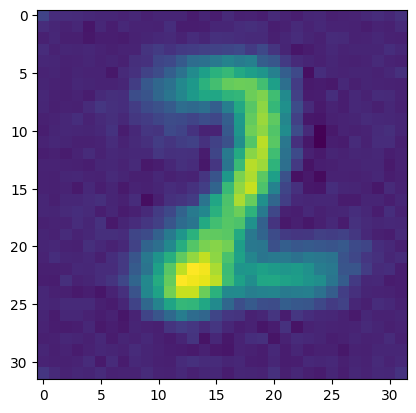

In [9]:
import matplotlib.pyplot as plt

sample = trans[0, 0, :, :]
plt.imshow(sample)
plt.show()

Accessing the latent spaces works analogously.

## 4) Visualize XModalix

XModalix results can be inspected by similar plots as other architectures:
- loss curves via `show_loss(plot_type="absolute|relative")`
- latent spaces via `show_latent_space(plot_type="Ridgeline|2D-scatter")`
Latent space plotting will plot for each VAE per modality and can be used to check if latent space alignment across modality was achieved during combined training.


### Loss curves
Loss curves can be plotted like for all autoencoders:

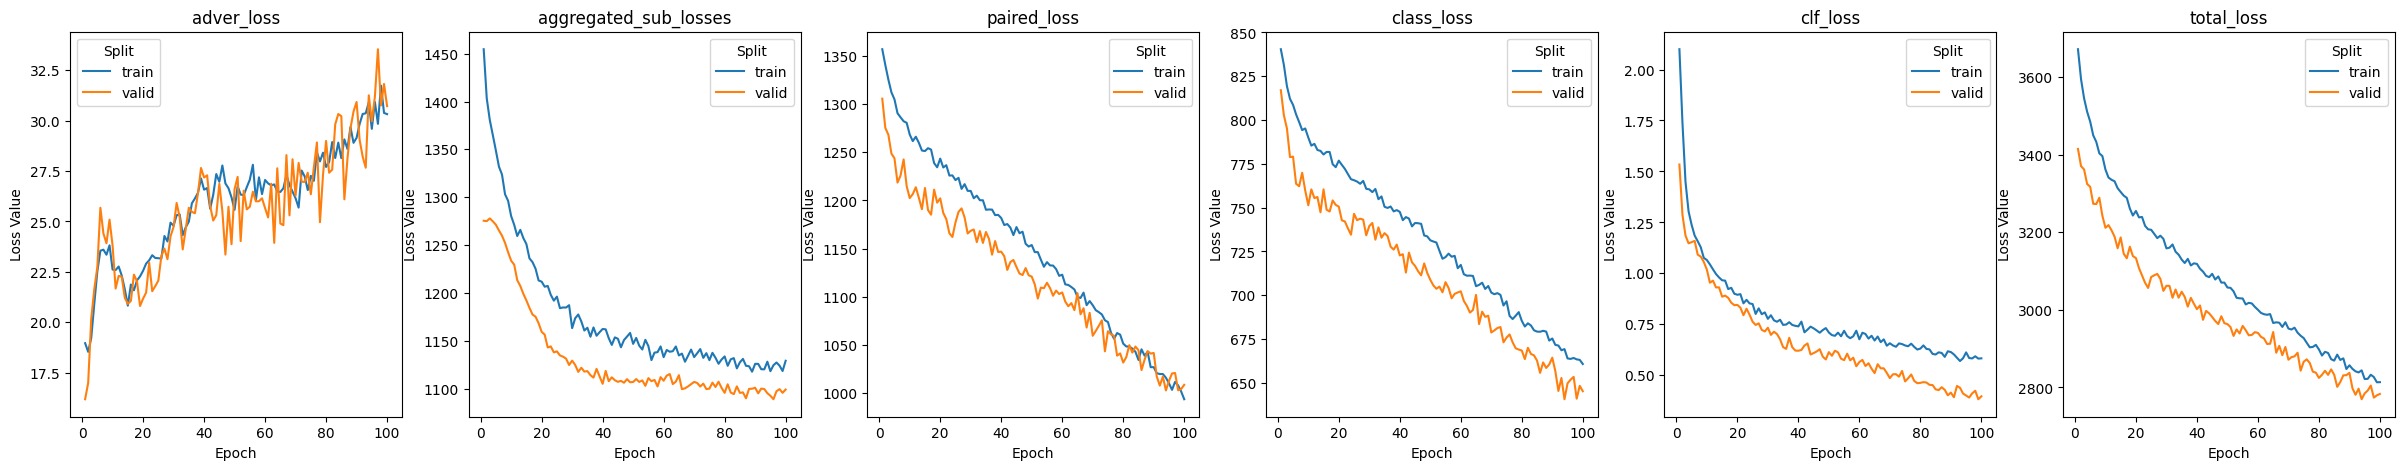

In [10]:
xmodalix.visualizer.show_loss(plot_type="absolute")

In `aggregated_sub_losses` all sub-VAE's are aggregated collecting their reconstruction losses as well as KL-divergence loss term. 

All sub-losses are stored in sub_loss attribute of the result where you can access individual VAE's like this: 

In [11]:
backup_result.sub_losses.get("multi_bulk.rna.recon_loss").get(split="train")[0:5] ## First five epochs of training reconstruction loss for RNA modality

array([1188.27111816, 1138.07058716, 1113.51846313, 1100.38330078,
       1080.73178101])

Due to the complexity of loss terms in XModalix, a relative contribution of loss terms to overall is useful to find best loss term weight combination:

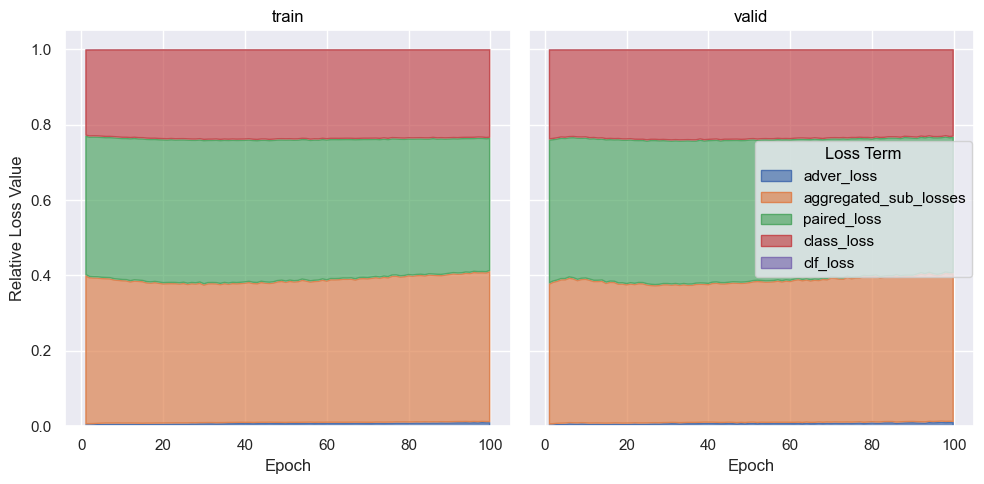

In [12]:
xmodalix.visualizer.show_loss(plot_type="relative")

### Latent space alignment
Latent space can be visualized as 2D representation or Ridgeline representation as before. But now for each modality. A good alignment will be visible if they match and show similarity:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


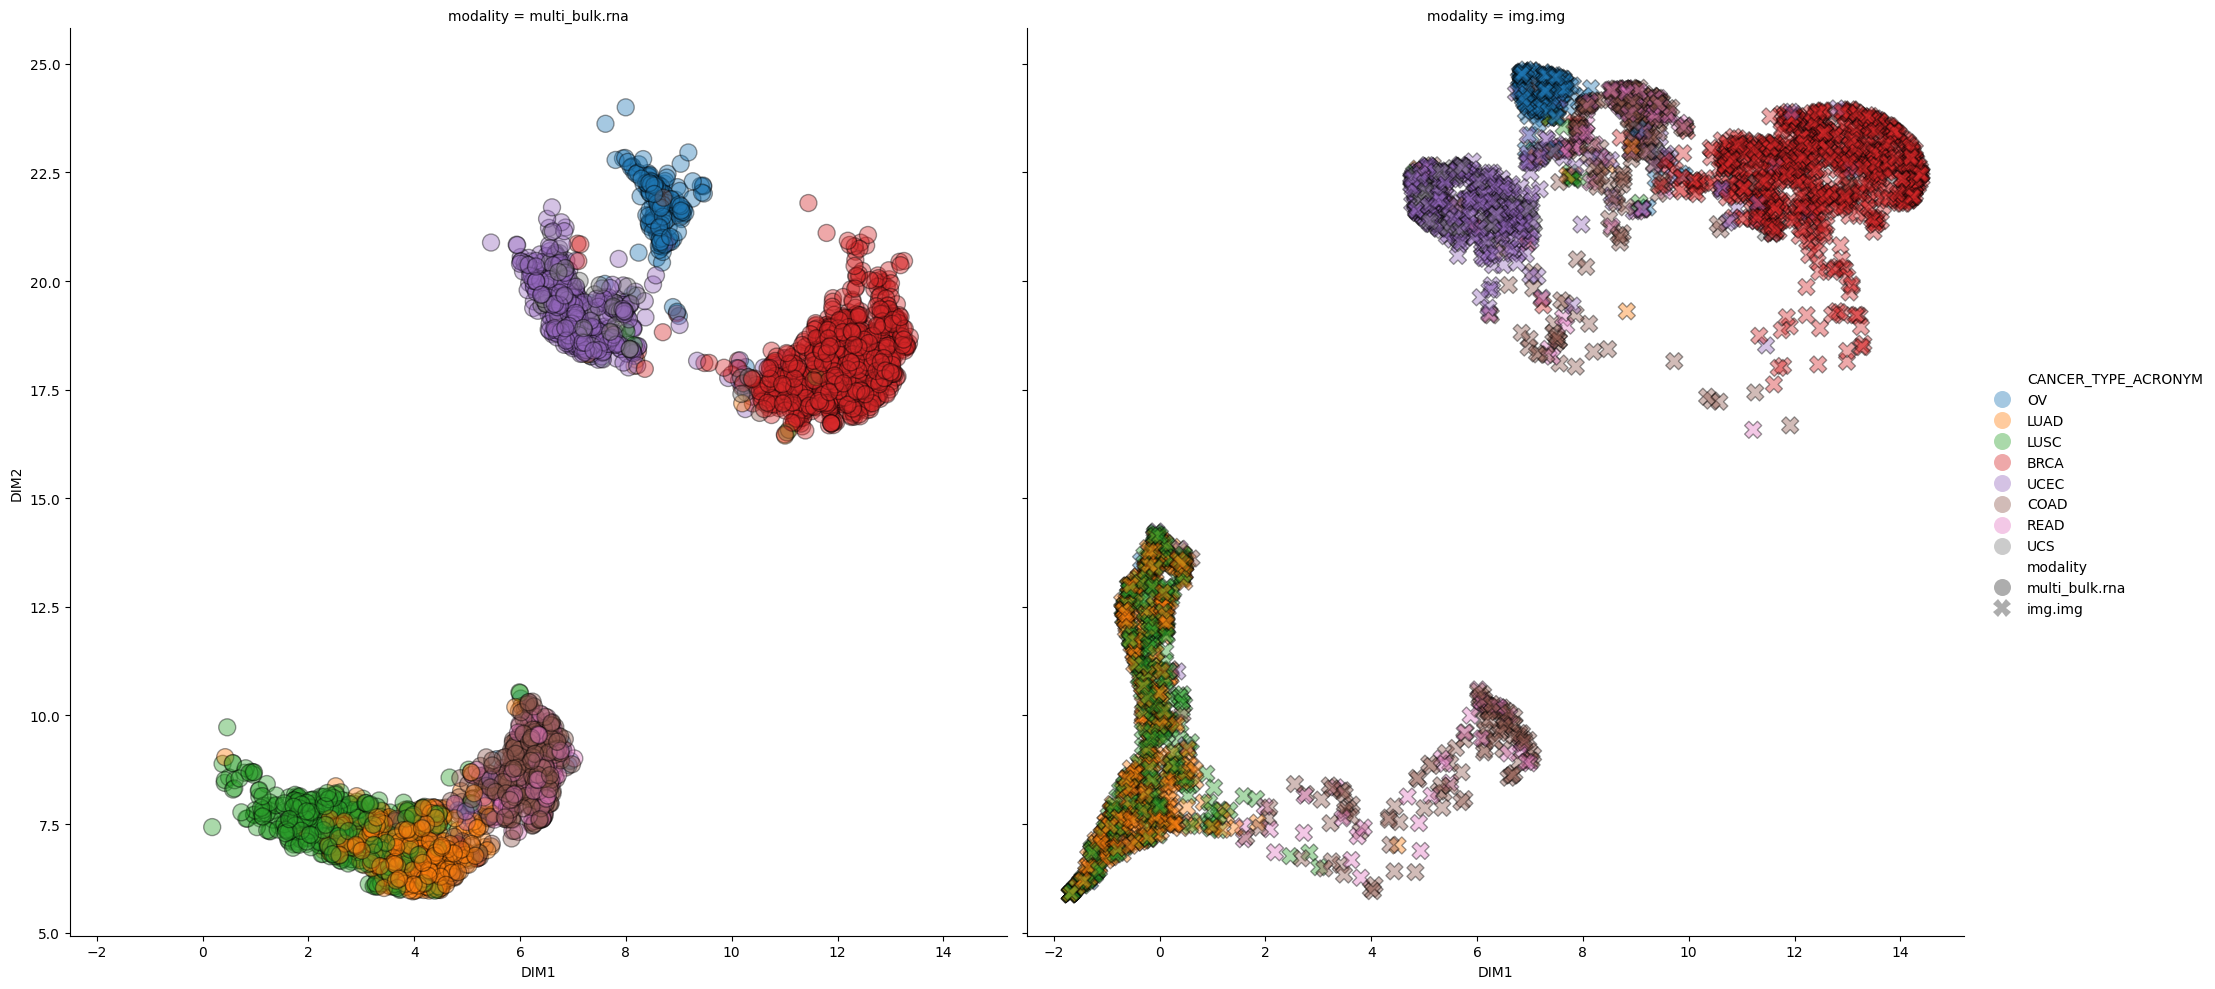

In [13]:
xmodalix.visualizer.show_latent_space(
	result=backup_result,
	plot_type="2D-scatter"
	)

### Specific XModalix visualizations
To inspect translation quality of XModalix reconstructions we provide two plots:
1) `show_2D_translation` shows a 2D representation created by e.g. UMAP of the high-dimensional input data vs. the reconstructed translation using the other modality as input
2) `show_image_translation` if your target modality for translation is an image, this can be used to visually compare original images to translated images (cross-modality) and reference images of the image VAE inside the XModalix.
A "good" XModalix can be seen in 1) if 2D representation of input and translation show high structural similarity and in 2) if translated images look similar to original images from the test-set which was not part of the training.

#### 2D translation

len of tensor-list: 646
len of tensor_ids: 646


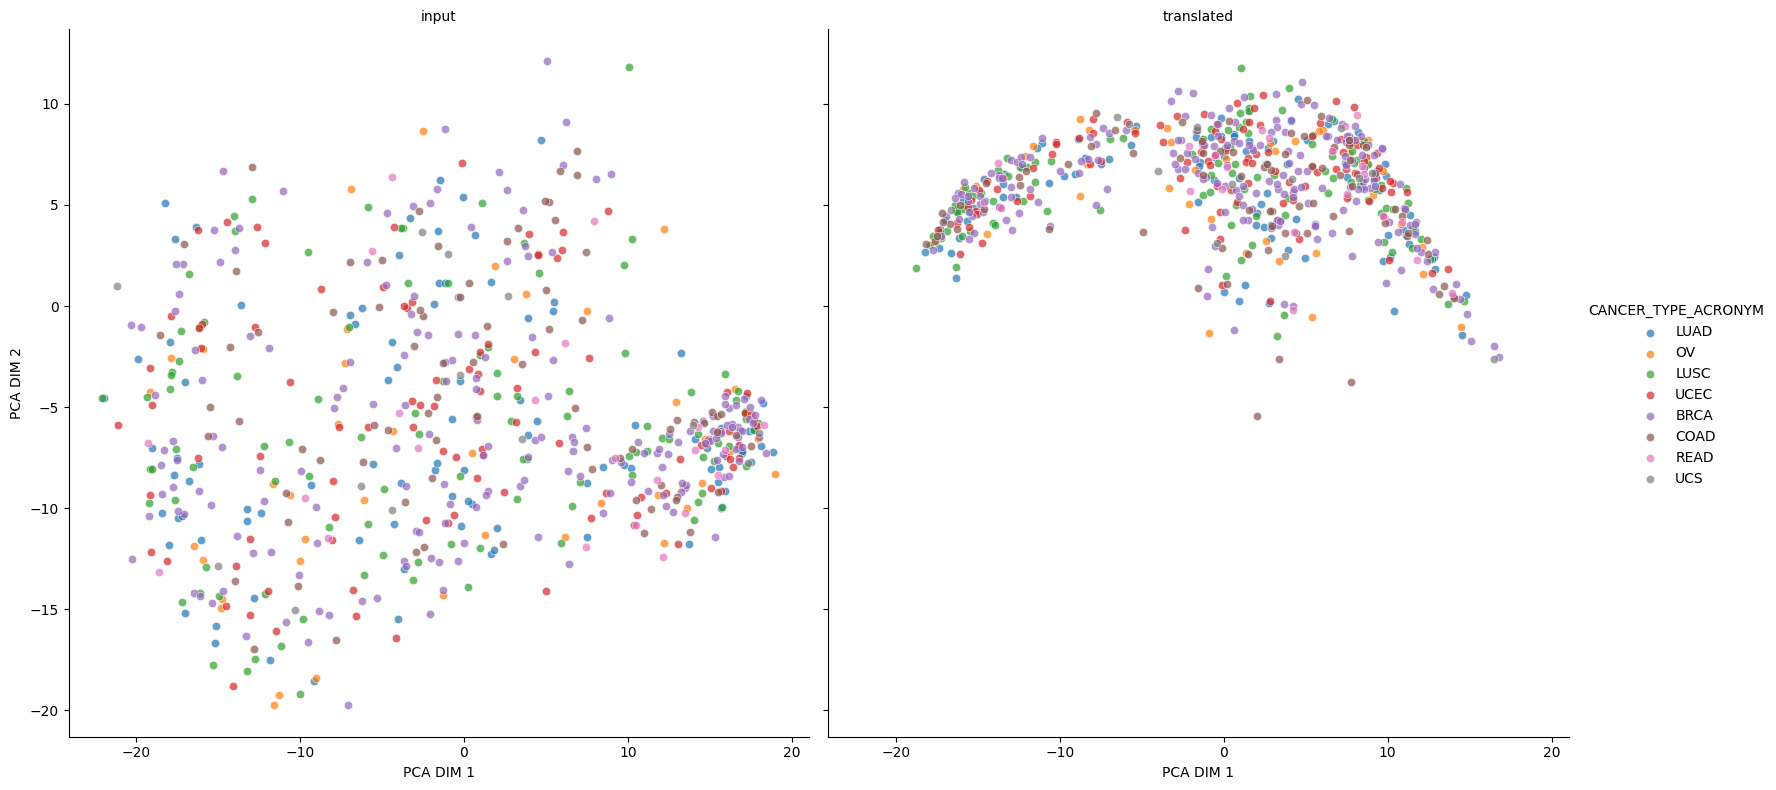

In [14]:
fig = xmodalix.visualizer.show_2D_translation(
	result=backup_result,
	translated_modality="img.img",
	param="CANCER_TYPE_ACRONYM",
	reducer="PCA",
)

#### Image translation

Sample per class: {'Non-Small Cell Lung Cancer': ['TCGA-60-2697-01', 'TCGA-22-5478-01', 'TCGA-37-5819-01'], 'Ovarian Epithelial Tumor': ['TCGA-61-1741-01', 'TCGA-25-2391-01', 'TCGA-25-2396-01'], 'Endometrial Cancer': ['TCGA-B5-A0JT-01', 'TCGA-D1-A0ZO-01', 'TCGA-A5-A0GQ-01'], 'Breast Cancer': ['TCGA-PL-A8LX-01', 'TCGA-EW-A1OZ-01', 'TCGA-A2-A25A-01'], 'Colorectal Cancer': ['TCGA-EI-6882-01', 'TCGA-CI-6623-01', 'TCGA-CM-6165-01']}


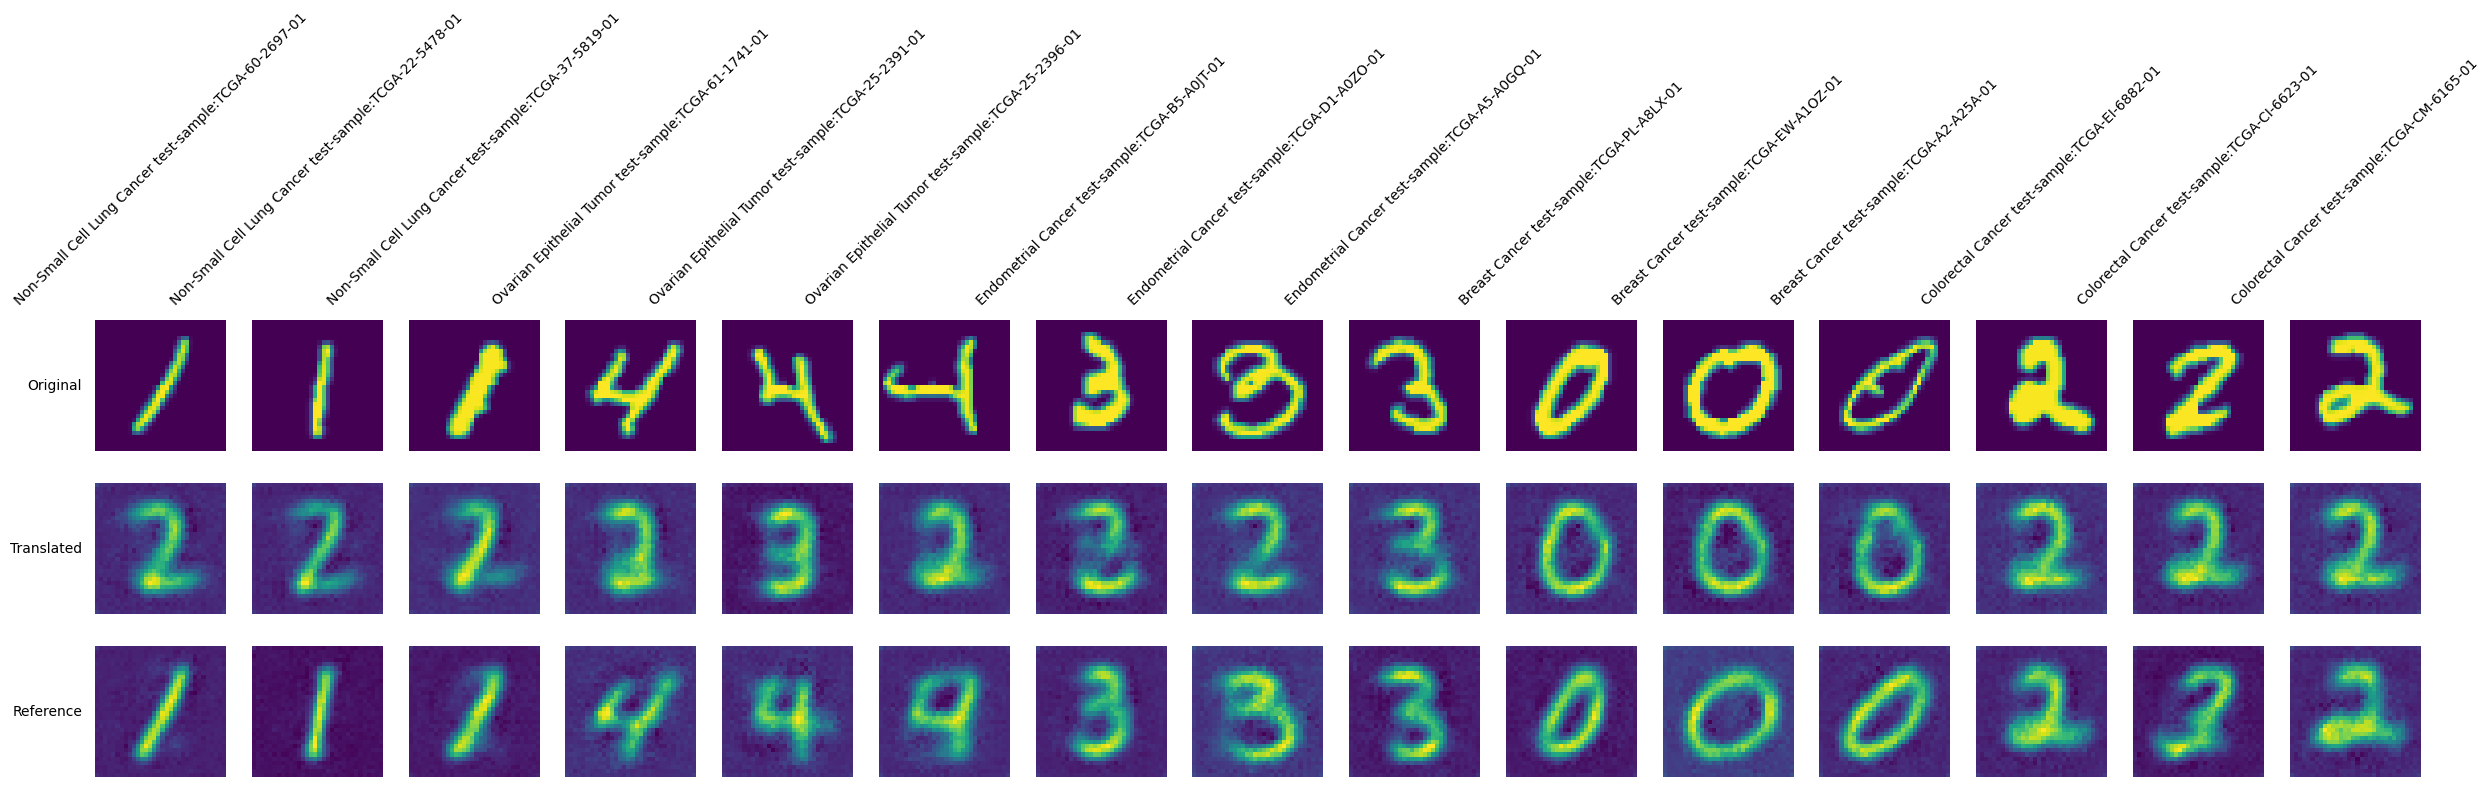

In [15]:
fig = xmodalix.visualizer.show_image_translation(  # ty: ignore
        result=backup_result,
        from_key ="mult_bulk.rna",
        to_key = "img.img",
		n_sample_per_class = 3,
        param = "CANCER_TYPE",
    )

## 5) Evaluate 

### 5.1 Embedding evaluation 
Beyond visual inspection and representation of XModalix results, you can evaluate VAE embeddings as before with the `evaluate` step. 

This will perform embedding evaluatation for downstream tasks similarly as for a normal VAE (`varix`). 

Since XModalix is composed of as many VAE's as modalities, each embedding will be evaluated independently. 

In [16]:
from sklearn.svm import SVC

my_classifier = SVC(kernel="rbf", probability=True) # You can provide any sklearn classifier here
my_metric = "roc_auc_ovo" # You can provide any sklearn metric here

params = ["CANCER_TYPE_ACRONYM"]
result = xmodalix.evaluate(
	ml_model_class = my_classifier,
	params=params,
	metric_class = my_metric,
	reference_methods= ["PCA"] # We compare XModalix embeddings to PCA embeddings
)



Perform ML task with feature df: PCA_$_multi_bulk.rna
PCA_$_multi_bulk.rna
Perform ML task with feature df: PCA_$_img.img
PCA_$_img.img
Perform ML task with feature df: Latent_$_multi_bulk.rna
Latent_$_multi_bulk.rna
Perform ML task for target parameter: CANCER_TYPE_ACRONYM


KeyError: "['TCGA-05-4417-01', 'TCGA-09-0364-01', 'TCGA-09-2051-01', 'TCGA-22-1000-01', 'TCGA-22-4607-01', 'TCGA-22-5477-01', 'TCGA-22-5489-01', 'TCGA-23-1111-01', 'TCGA-23-2077-01', 'TCGA-29-1694-01', 'TCGA-29-1702-01', 'TCGA-29-1785-01', 'TCGA-29-2427-01', 'TCGA-34-5234-01', 'TCGA-34-5928-01', 'TCGA-34-5929-01', 'TCGA-37-A5EL-01', 'TCGA-38-4625-01', 'TCGA-39-5022-01', 'TCGA-3L-AA1B-01', 'TCGA-44-7670-01', 'TCGA-44-A47A-01', 'TCGA-46-3769-01', 'TCGA-49-4507-01', 'TCGA-50-8457-01', 'TCGA-52-7812-01', 'TCGA-55-1592-01', 'TCGA-55-1594-01', 'TCGA-55-6712-01', 'TCGA-55-6978-01', 'TCGA-55-7913-01', 'TCGA-55-8087-01', 'TCGA-55-8096-01', 'TCGA-55-8619-01', 'TCGA-56-A49D-01', 'TCGA-58-8386-01', 'TCGA-5T-A9QA-01', 'TCGA-63-6202-01', 'TCGA-63-A5MJ-01', 'TCGA-63-A5MY-01', 'TCGA-64-1680-01', 'TCGA-66-2755-01', 'TCGA-66-2787-01', 'TCGA-66-2791-01', 'TCGA-67-6216-01', 'TCGA-69-7765-01', 'TCGA-69-7979-01', 'TCGA-69-8255-01', 'TCGA-77-8150-01', 'TCGA-77-A5G3-01', 'TCGA-78-7155-01', 'TCGA-78-8655-01', 'TCGA-85-6175-01', 'TCGA-85-7844-01', 'TCGA-85-A4QQ-01', 'TCGA-85-A53L-01', 'TCGA-86-8074-01', 'TCGA-86-8585-01', 'TCGA-91-6828-01', 'TCGA-91-6829-01', 'TCGA-91-6848-01', 'TCGA-93-A4JN-01', 'TCGA-97-7937-01', 'TCGA-97-8175-01', 'TCGA-97-8177-01', 'TCGA-97-8552-01', 'TCGA-97-A4M2-01', 'TCGA-A1-A0SJ-01', 'TCGA-A1-A0SQ-01', 'TCGA-A2-A04X-01', 'TCGA-A2-A0CQ-01', 'TCGA-A5-A0GA-01', 'TCGA-A5-A0GE-01', 'TCGA-A5-A1OJ-01', 'TCGA-A5-AB3J-01', 'TCGA-A6-2675-01', 'TCGA-A6-2681-01', 'TCGA-A6-4107-01', 'TCGA-A6-5667-01', 'TCGA-A7-A0CE-01', 'TCGA-A7-A0CH-01', 'TCGA-A7-A2KD-01', 'TCGA-A7-A3RF-01', 'TCGA-A7-A6VV-01', 'TCGA-A8-A06N-01', 'TCGA-A8-A09A-01', 'TCGA-AA-3489-01', 'TCGA-AA-3529-01', 'TCGA-AA-3531-01', 'TCGA-AA-3532-01', 'TCGA-AA-3844-01', 'TCGA-AA-3851-01', 'TCGA-AA-3979-01', 'TCGA-AC-A23E-01', 'TCGA-AC-A2B8-01', 'TCGA-AC-A3YI-01', 'TCGA-AC-A5XU-01', 'TCGA-AC-A8OQ-01', 'TCGA-AD-6548-01', 'TCGA-AG-3725-01', 'TCGA-AG-3742-01', 'TCGA-AH-6544-01', 'TCGA-AH-6644-01', 'TCGA-AJ-A3BI-01', 'TCGA-AJ-A3EK-01', 'TCGA-AN-A0FD-01', 'TCGA-AN-A0FK-01', 'TCGA-AN-A0FX-01', 'TCGA-AO-A03O-01', 'TCGA-AO-A12E-01', 'TCGA-AO-A1KP-01', 'TCGA-AP-A052-01', 'TCGA-AP-A054-01', 'TCGA-AP-A0LJ-01', 'TCGA-AP-A0LN-01', 'TCGA-AP-A1E4-01', 'TCGA-AP-A5FX-01', 'TCGA-AQ-A0Y5-01', 'TCGA-AR-A0TV-01', 'TCGA-AR-A1AQ-01', 'TCGA-AR-A24O-01', 'TCGA-AR-A2LN-01', 'TCGA-AX-A06F-01', 'TCGA-AX-A1CF-01', 'TCGA-AY-4071-01', 'TCGA-AY-6196-01', 'TCGA-AY-A54L-01', 'TCGA-AZ-4315-01', 'TCGA-AZ-4323-01', 'TCGA-B5-A11L-01', 'TCGA-B5-A1MX-01', 'TCGA-B5-A1N2-01', 'TCGA-B5-A5OC-01', 'TCGA-B6-A0I2-01', 'TCGA-B6-A0IG-01', 'TCGA-BG-A0M7-01', 'TCGA-BG-A0MG-01', 'TCGA-BG-A0MT-01', 'TCGA-BG-A186-01', 'TCGA-BG-A2AE-01', 'TCGA-BH-A0BC-01', 'TCGA-BH-A0DD-01', 'TCGA-BH-A0DQ-01', 'TCGA-BH-A0H7-01', 'TCGA-BH-A0HP-01', 'TCGA-BS-A0TG-01', 'TCGA-C8-A133-01', 'TCGA-C8-A274-01', 'TCGA-CA-6719-01', 'TCGA-CK-6751-01', 'TCGA-CM-4746-01', 'TCGA-CM-5862-01', 'TCGA-CM-6169-01', 'TCGA-D1-A17S-01', 'TCGA-D1-A2G6-01', 'TCGA-D5-6535-01', 'TCGA-D8-A147-01', 'TCGA-D8-A1XB-01', 'TCGA-D8-A1XG-01', 'TCGA-D8-A1Y0-01', 'TCGA-D8-A27F-01', 'TCGA-D8-A27N-01', 'TCGA-DF-A2KS-01', 'TCGA-DM-A1DB-01', 'TCGA-DM-A285-01', 'TCGA-E2-A14Z-01', 'TCGA-E2-A153-01', 'TCGA-E2-A159-01', 'TCGA-E2-A15F-01', 'TCGA-E2-A15S-01', 'TCGA-E2-A1II-01', 'TCGA-E2-A1IK-01', 'TCGA-E2-A1LA-01', 'TCGA-E6-A1LZ-01', 'TCGA-E6-A1M0-01', 'TCGA-E9-A1RE-01', 'TCGA-E9-A226-01', 'TCGA-E9-A22D-01', 'TCGA-EI-6511-01', 'TCGA-EO-A3KX-01', 'TCGA-EO-A3L0-01', 'TCGA-EW-A1PH-01', 'TCGA-EY-A1GC-01', 'TCGA-EY-A1GI-01', 'TCGA-EY-A4KR-01', 'TCGA-F4-6461-01', 'TCGA-F5-6702-01', 'TCGA-F5-6814-01', 'TCGA-FI-A2D5-01', 'TCGA-FI-A2EU-01', 'TCGA-G4-6298-01', 'TCGA-G4-6306-01', 'TCGA-G4-6586-01', 'TCGA-GM-A2DF-01', 'TCGA-HN-A2NL-01', 'TCGA-L3-A4E7-01', 'TCGA-LD-A9QF-01', 'TCGA-LL-A6FP-01', 'TCGA-MP-A4SV-01', 'TCGA-N5-A4RU-01', 'TCGA-N9-A4Q1-01', 'TCGA-N9-A4Q4-01', 'TCGA-ND-A4WC-01', 'TCGA-NF-A4X2-01', 'TCGA-NK-A5CR-01', 'TCGA-OL-A66H-01', 'TCGA-OL-A66I-01', 'TCGA-OL-A66P-01', 'TCGA-PG-A5BC-01', 'TCGA-PG-A916-01', 'TCGA-QL-A97D-01', 'TCGA-S2-AA1A-01', 'TCGA-S3-A6ZG-01'] not in index"

Then we can visualize the evaluation results as bar plots

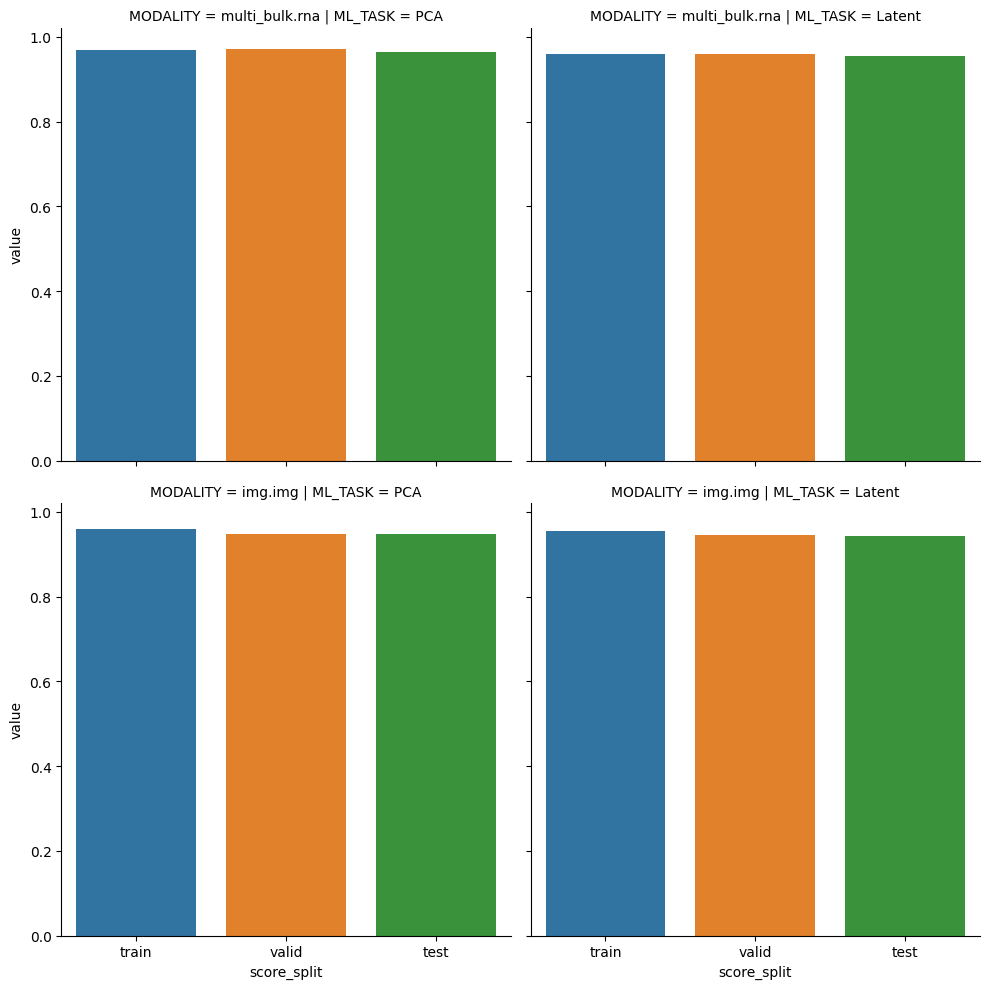

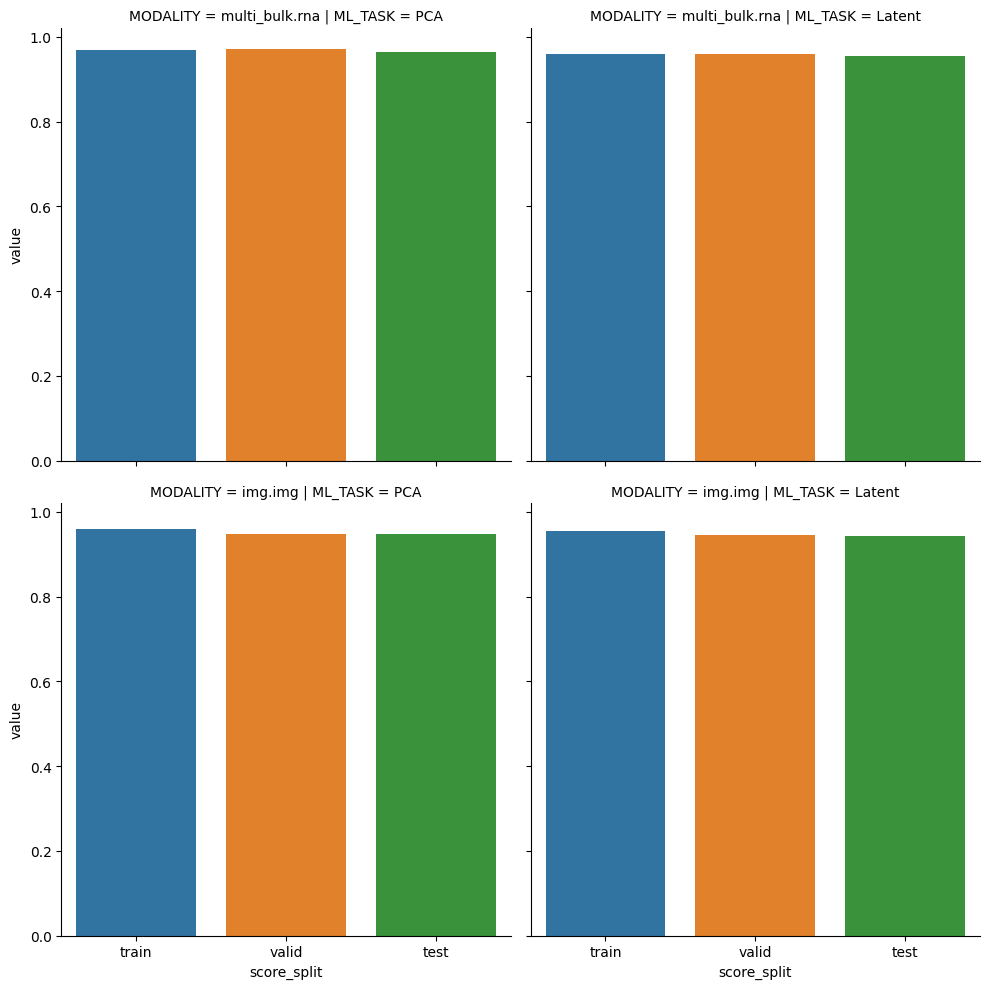

In [ ]:
fig = xmodalix.visualizer.show_evaluation(
	param=params[0], 	# Only one param at a time
	metric = my_metric,		# Needs to be specificied in case multiple metrics were used
	ml_alg=str(my_classifier),	# Needs to be specificied in case multiple classifiers were used
)

We can see that both image VAE (bottom, right) and RNA VAE (top, right) latent space embeddings have similar predictive power for cancer type classification. 

### 5.2 Comparison to a Imagix
Since XModalix VAE's for each modalities are coupled by a joint loss, we offer a function `xmodalix.evaluator.pure_vae_comparison()` for the image case which will compare translated (`from` -> `to` modality) and reference (`to` -> `to`) image reconstructions of XModalix with a pure image VAE (Imagix) reconstruction capability. 

Prior comparison this pure Imagix needs to be trained on the same data and ideally with a similar config as the XModalix:

In [ ]:
from autoencodix.configs.default_config import DefaultConfig

imagix_config = 	DefaultConfig(
    checkpoint_interval=100,
    epochs=100,
    beta=0.1,
    latent_dim=6,
    batch_size=512,
    learning_rate=0.0005,
    loss_reduction="sum",
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                img_height_resize=32,
                img_width_resize=32,
                data_type="IMG",
                scaling="STANDARD",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
        annotation_columns=["CANCER_TYPE_ACRONYM"],
    ),
)

In [ ]:
imagix = acx.Imagix(config=imagix_config)
imagix_result = imagix.run()

Given image size is possible, rescaling images to: 32x32
Successfully loaded 3230 images for img
calling normalize image in _process_ing_to_img_case
anno key: img
Converting 2261 images to torch.float32 tensors...
Converting 646 images to torch.float32 tensors...
Converting 323 images to torch.float32 tensors...
Epoch 1 - Train Loss: 1351.9486
Sub-losses: recon_loss: 1351.9485, var_loss: 0.0001, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 1024.5770
Sub-losses: recon_loss: 1024.5770, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 978.4705
Sub-losses: recon_loss: 978.4704, var_loss: 0.0001, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 1024.8597
Sub-losses: recon_loss: 1024.8597, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 840.9508
Sub-losses: recon_loss: 840.9507, var_loss: 0.0001, anneal_factor: 0.0001, effective_beta_factor: 0.0000


Before we make the comparison, we can quickly check the imagix reconstruction capability with `imagix.visualizer.show_image_recon_grid()` showing original and reconstructed images from the test-split. 

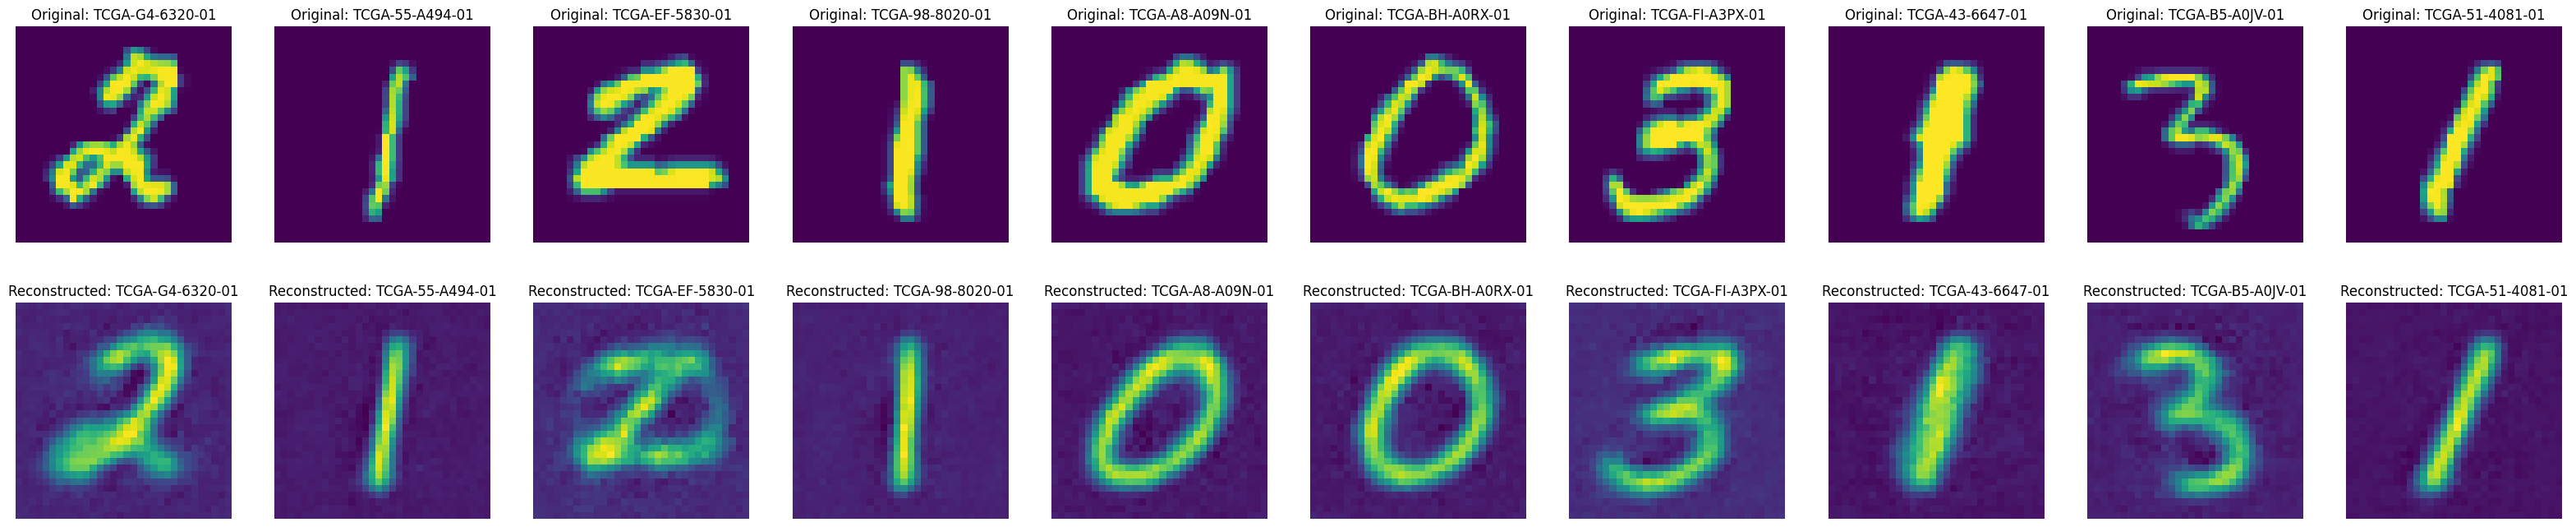

In [ ]:
fig_imagix = imagix.visualizer.show_image_recon_grid(
	result=imagix_result,
	n_samples = 10, # Number of (random) test samples to show
)

Looks good with small deviations. Let's compare with the XModalix:

In [ ]:
param = "CANCER_TYPE" # Aggregate over a metadata parameter
fig_pure_comparison, df_comparison = xmodalix.evaluator.pure_vae_comparison(
	xmodalix_result = backup_result, # The XModalix for comparison
	pure_vae_result = imagix.result, # The pure VAE (Imagix) for comparison
	to_key = "img.img", # The translated modality key
	param = param # The metadata parameter to aggregate over. If None, all test samples are shown individually
)

A visualization is created:


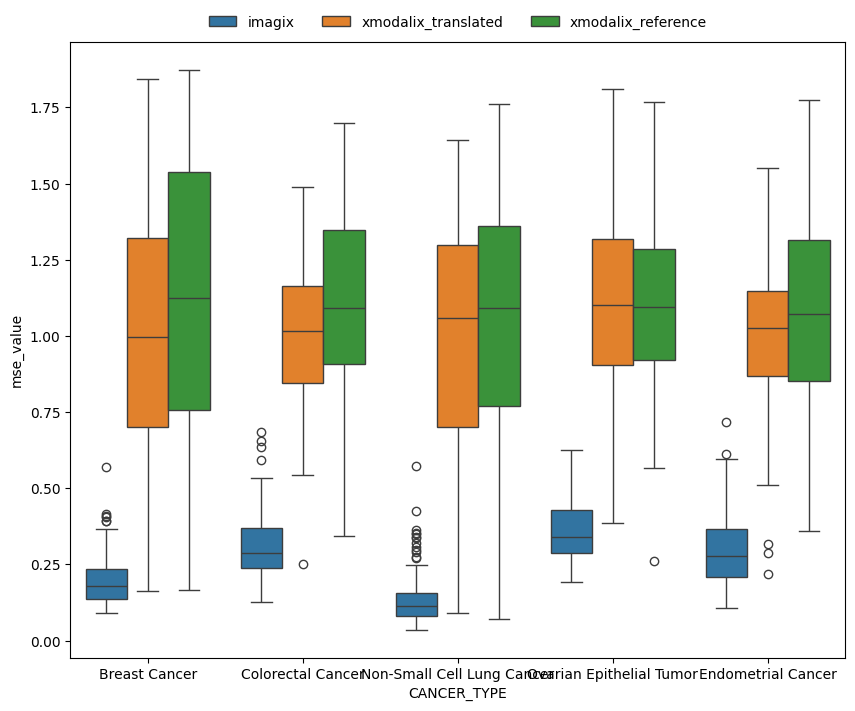

In [ ]:
fig_pure_comparison.get_figure()

## 6) Apply Custom Parameters
Due to the more complex training, we have more config parameters to customize. Here we go over the different `loss terms` and `pretraining`.
```python
    gamma: float = Field(
        default=10.0,
        ge=0,
        description="Gamma weighting factor for Adversial Loss Term i.e. for XModal Classfier training",
    )
    delta_pair: float = Field(
        default=5.0,
        ge=0,
        description="Delta weighting factor for paired loss term in XModale Training",
    )
    delta_class: float = Field(
        default=5.0,
        ge=0,
        description="Delta weighting factor for class loss term in XModale Training",
    )
```
The correct parametrization of these terms depends heavily on your data. We provide sensible default values in our `XModalixConfig` class, which are a good starting point. You can investigate the loss plots to see how much each loss contributes. For example, if your goal is to strongly preserve class information in the latent embedding, you would set `delta_class` higher. If you care more about generalization, you might set `gamma` higher.

Another important factor is pretraining. Before training a modality within the full XModalix architecture, we can pretrain that modality in its subnetwork without the XModalix constraints (adversarial, paired, class loss). This can be controlled via the `pretrain_epochs` parameter, which can be set either globally for all data modalities or individually per modality. Both options are shown below.


In [ ]:
import autoencodix as acx
from autoencodix.configs.xmodalix_config import XModalixConfig
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase


xmodalix_config = XModalixConfig(
    class_param="CANCER_TYPE_ACRONYM",
    gamma=2,
    delta_class=10.0,  # increase this if you care about class info in embedding
    delta_pair=3.0,
    requires_paired=False,
    pretrain_epochs=2,  # can be overridden on data level, see below
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path="YOUR_PATH",
                data_type="IMG",
                translate_direction="to",
                pretrain_epochs=2,  # this overrides global pretraining_epochs
            ),
            "rna": DataInfo(
                file_path="YOUR_PATH",
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path="YOUR_PATH", data_type="ANNOTATION", sep="\t"),
        },
    ),
)

## 7) Save, Load and Re-use XModalix

This works for `XModalix` as for any other models, by using the `save` and `load` methods.

In [ ]:
import os
import glob

outpath = os.path.join("xmodalix")
xmodalix.save(file_path=outpath, save_all=False)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
xmodalix_loaded = acx.XModalix.load(outpath)
# now you can use the model to predict with a different pair again:
testdata = backup_result.datasets
r = xmodalix_loaded.predict(data=testdata)

Preprocessor saved successfully.
saving memory efficient
Pipeline object saved successfully.
PKL files: ['ontix_backup_preprocessor.pkl', 'ontix_backup.pkl']
Model files: ['ontix_backup_model.pth']
Attempting to load a pipeline from ./xmodalix...
Pipeline object loaded successfully. Actual type: XModalix
Preprocessor loaded successfully.
Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.rna'
  - Added 1000 source feature IDs to .uns
Finished processing latent results.
